In [126]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [66]:
df = pd.read_csv("../data/record_df.csv")

In [169]:
drop = ["Unnamed: 0","IDLink","Source","PublishDate"]
dfn = df.drop(drop,1)

logmarker = ["sum-tpop-", "sum-tavg-","POPU","sum-popu","last-popu"]
for i in dfn.columns:
    for j in logmarker:
        if j in i:
            dfn[i] = np.log(2+dfn[i].values)
            
dfn.head()

,Topic,sentimenttitle,sentimenthead,publish-tp,last-popu,sum-popu,sum-tpop-0,sum-tpop-1,sum-tpop-2,sum-tpop-3,...,sum-tavg-1,sum-tavg-2,sum-tavg-3,sum-tavg-4,sum-tavg-5,sum-tavg-6,sum-tavg-7,sum-tavg-8,sum-tavg-9,POPU
0,economy,0.094491,-0.011282,29,0.693147,0.000000,5.323010,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,7.595890
1,economy,0.094491,-0.011282,30,7.595890,7.595387,8.178919,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
2,economy,0.094491,-0.011282,31,0.693147,7.595387,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
3,economy,0.094491,-0.011282,32,0.693147,7.595387,0.693147,5.323010,0.693147,0.693147,...,3.200938,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
4,economy,0.094491,-0.011282,33,0.693147,7.595387,0.693147,8.178919,0.693147,0.693147,...,4.085434,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147


In [203]:
dfn = dfn[dfn["POPU"]>5]
print(dfn.shape)
X, y = dfn.drop(['POPU'],1).values,dfn['POPU'].values
from collections import Counter
Counter(dfn["Topic"])

(3412, 37)


Counter({'economy': 279, 'microsoft': 94, 'obama': 2961, 'palestine': 78})

In [204]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    CV_scores = []
    test_scores = []
    r2_scores = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    for train_index, CV_index in kf.split(X_other,y_other):

        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        # preprocessing
        mmx_ft = np.arange(3,36)
        ohe_ft = [0]
        kpt_ft = [1,2]
        
        scaler = MinMaxScaler()
        X_train_mmx = scaler.fit_transform(X_train[:,mmx_ft])
        X_c_mmx = scaler.transform(X_CV[:,mmx_ft])
        X_t_mmx = scaler.transform(X_test[:,mmx_ft])
        
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
        X_train_ohe = ohe.fit_transform(X_train[:,ohe_ft])
        X_c_ohe = ohe.transform(X_CV[:,ohe_ft])
        X_t_ohe = ohe.transform(X_test[:,ohe_ft])
        
        X_train = np.concatenate((X_train_mmx, X_train_ohe, X_train[:,kpt_ft]),axis=1)
        X_c = np.concatenate((X_c_mmx, X_c_ohe, X_CV[:,kpt_ft]),axis=1)
        X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
        
        # tune ridge hyper-parameter, alpha
        mds = np.arange(6,11)
        mss = [0.025, 0.05, 0.1, 0.2]
        train_score = []
        CV_score = []
        regs = []
        params = []
        for md in mds:
            for ms in mss:
                params.append((md,ms))
#                 reg = RandomForestRegressor(max_depth = md, n_estimators = 100, min_samples_split = ms, random_state = 42)
#                 reg.fit(X_train,y_train)
#                 train_score.append(mean_squared_error(y_train,reg.predict(X_train)))
#                 CV_score.append(mean_squared_error(y_CV,reg.predict(X_c)))
#                 regs.append(reg)

                rs_train_score = []
                rs_CV_score = []
                for rstt in [42,84,126]:
                    reg = RandomForestRegressor(max_depth = md, n_estimators = 100, min_samples_split = ms, random_state = rstt)
                    reg.fit(X_train,y_train)
                    rs_train_score.append(mean_squared_error(y_train,reg.predict(X_train)))
                    rs_CV_score.append(mean_squared_error(y_CV,reg.predict(X_c)))
                regs.append(reg)
                train_score.append(np.mean(rs_train_score))
                CV_score.append(np.mean(rs_CV_score))

        # find the best alpha in this fold
        CV_score = np.array(CV_score)
        best_c = params[np.argmin(CV_score)]
        # grab the best model
        reg = regs[np.argmin(CV_score)]
        CV_scores.append(np.min(CV_score))
        # calculate test score using thee best model
        test_scores.append(mean_squared_error(y_test,reg.predict(X_t)))
        r2_scores.append(r2_score(y_test,reg.predict(X_t)))
        
    return CV_scores,test_scores, r2_scores, best_c, reg.feature_importances_

#ML_pipeline_kfold(dfn.drop(['POPU'],1).values, dfn['POPU'].values,42,5)

In [205]:
test_scores = []
r2_scores = []
f_imps = []
for rs in range(1,11):
    cv_score, test_score, r2_scr, best_c, f_imp = ML_pipeline_kfold(X, y ,rs * 42, 5)
    test_scores.append(test_score)
    r2_scores.append(r2_scr)
    f_imps.append(f_imp)
    print("best_maxdepth is : ", best_c[0], "\t best_minsplit is : ", best_c[1], "\t avg_MSE is : ", round(np.mean(test_score),2), "\t avg_R2 is : ", round(np.mean(r2_scr),2))
print('MSE :',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
print('R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),2))
print('feature_importance :')
feature_imp = [(x,y) for x,y in zip(['Topic0', 'Topic1', 'Topic2']+list(dfn.columns)[:-1], np.around(np.mean(f_imps,0),3))]
feature_imp.sort(key = lambda x: -x[1])
for f, i in feature_imp:
    print(f.ljust(20),i)

best_maxdepth is :  7 	 best_minsplit is :  0.025 	 avg_MSE is :  0.35 	 avg_R2 is :  0.47
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.37 	 avg_R2 is :  0.47
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.38 	 avg_R2 is :  0.47
best_maxdepth is :  9 	 best_minsplit is :  0.025 	 avg_MSE is :  0.39 	 avg_R2 is :  0.41
best_maxdepth is :  8 	 best_minsplit is :  0.05 	 avg_MSE is :  0.4 	 avg_R2 is :  0.43
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.36 	 avg_R2 is :  0.46
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.36 	 avg_R2 is :  0.47
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.34 	 avg_R2 is :  0.48
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.34 	 avg_R2 is :  0.47
best_maxdepth is :  10 	 best_minsplit is :  0.025 	 avg_MSE is :  0.33 	 avg_R2 is :  0.47
MSE : 0.36 +/- 0.02
R2 : 0.46 +/- 0.02
feature_importance :
Topic1               0.40

In [175]:
from sklearn.ensemble import GradientBoostingRegressor

In [208]:
def ML_pipeline_kfold_GBR(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    CV_scores = []
    test_scores = []
    r2_scores = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    for train_index, CV_index in kf.split(X_other,y_other):

        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        # preprocessing
        mmx_ft = np.arange(3,36)
        ohe_ft = [0]
        kpt_ft = [1,2]
        
        scaler = MinMaxScaler()
        X_train_mmx = scaler.fit_transform(X_train[:,mmx_ft])
        X_c_mmx = scaler.transform(X_CV[:,mmx_ft])
        X_t_mmx = scaler.transform(X_test[:,mmx_ft])
        
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
        X_train_ohe = ohe.fit_transform(X_train[:,ohe_ft])
        X_c_ohe = ohe.transform(X_CV[:,ohe_ft])
        X_t_ohe = ohe.transform(X_test[:,ohe_ft])
        
        X_train = np.concatenate((X_train_mmx, X_train_ohe, X_train[:,kpt_ft]),axis=1)
        X_c = np.concatenate((X_c_mmx, X_c_ohe, X_CV[:,kpt_ft]),axis=1)
        X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
        
        # tune ridge hyper-parameter, alpha
        mds = np.arange(3,9)
        mss = [0.025, 0.05, 0.1, 0.2]
        train_score = []
        CV_score = []
        regs = []
        params = []
        for md in mds:
            for ms in mss:
                params.append((md,ms))
#                 reg = GradientBoostingRegressor(max_depth = md, n_estimators = 100, min_samples_split = ms, random_state = 42)
#                 reg.fit(X_train,y_train)
#                 train_score.append(mean_squared_error(y_train,reg.predict(X_train)))
#                 CV_score.append(mean_squared_error(y_CV,reg.predict(X_c)))
#                 regs.append(reg)
                
                rs_train_score = []
                rs_CV_score = []
                for rstt in [42,84,126]:
                    reg = RandomForestRegressor(max_depth = md, n_estimators = 100, min_samples_split = ms, random_state = rstt)
                    reg.fit(X_train,y_train)
                    rs_train_score.append(mean_squared_error(y_train,reg.predict(X_train)))
                    rs_CV_score.append(mean_squared_error(y_CV,reg.predict(X_c)))
                regs.append(reg)
                train_score.append(np.mean(rs_train_score))
                CV_score.append(np.mean(rs_CV_score))

        # find the best alpha in this fold
        CV_score = np.array(CV_score)
        best_c = params[np.argmin(CV_score)]
        # grab the best model
        reg = regs[np.argmin(CV_score)]
        CV_scores.append(np.min(CV_score))
        # calculate test score using thee best model
        test_scores.append(mean_squared_error(y_test,reg.predict(X_t)))
        r2_scores.append(r2_score(y_test,reg.predict(X_t)))
        
    return CV_scores,test_scores, r2_scores, best_c, reg.feature_importances_

#ML_pipeline_kfold(dfn.drop(['POPU'],1).values, dfn['POPU'].values,42,5)

In [209]:
test_scores = []
r2_scores = []
f_imps = []
for rs in range(1,11):
    cv_score, test_score, r2_scr, best_c, f_imp = ML_pipeline_kfold_GBR(X, y ,rs * 42, 5)
    test_scores.append(test_score)
    r2_scores.append(r2_scr)
    f_imps.append(f_imp)
    print("best_maxdepth is : ", best_c[0], "\t best_minsplit is : ", best_c[1], "\t avg_MSE is : ", round(np.mean(test_score),2), "\t avg_R2 is : ", round(np.mean(r2_scr),2))
print('MSE :',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
print('R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),2))
print('feature_importance :')
feature_imp = [(x,y) for x,y in zip(['Topic0', 'Topic1', 'Topic2']+list(dfn.columns)[:-1], np.around(np.mean(f_imps,0),3))]
feature_imp.sort(key = lambda x: -x[1])
for f, i in feature_imp:
    print(f.ljust(20),i)

best_maxdepth is :  5 	 best_minsplit is :  0.1 	 avg_MSE is :  0.35 	 avg_R2 is :  0.47
best_maxdepth is :  4 	 best_minsplit is :  0.1 	 avg_MSE is :  0.38 	 avg_R2 is :  0.45
best_maxdepth is :  6 	 best_minsplit is :  0.1 	 avg_MSE is :  0.38 	 avg_R2 is :  0.46
best_maxdepth is :  7 	 best_minsplit is :  0.2 	 avg_MSE is :  0.39 	 avg_R2 is :  0.4
best_maxdepth is :  4 	 best_minsplit is :  0.025 	 avg_MSE is :  0.41 	 avg_R2 is :  0.43
best_maxdepth is :  7 	 best_minsplit is :  0.025 	 avg_MSE is :  0.36 	 avg_R2 is :  0.45
best_maxdepth is :  6 	 best_minsplit is :  0.025 	 avg_MSE is :  0.38 	 avg_R2 is :  0.44
best_maxdepth is :  3 	 best_minsplit is :  0.1 	 avg_MSE is :  0.35 	 avg_R2 is :  0.47
best_maxdepth is :  7 	 best_minsplit is :  0.1 	 avg_MSE is :  0.35 	 avg_R2 is :  0.45
best_maxdepth is :  6 	 best_minsplit is :  0.05 	 avg_MSE is :  0.35 	 avg_R2 is :  0.45
MSE : 0.37 +/- 0.02
R2 : 0.45 +/- 0.02
feature_importance :
Topic1               0.352
Topic0           

In [184]:
from sklearn.svm import SVR

In [210]:
def ML_pipeline_kfold_SVR(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    CV_scores = []
    test_scores = []
    r2_scores = []
    # k folds - each fold will give us a CV and a test score
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    for train_index, CV_index in kf.split(X_other,y_other):

        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
        # preprocessing
        mmx_ft = np.arange(3,36)
        ohe_ft = [0]
        kpt_ft = [1,2]
        
        scaler = MinMaxScaler()
        X_train_mmx = scaler.fit_transform(X_train[:,mmx_ft])
        X_c_mmx = scaler.transform(X_CV[:,mmx_ft])
        X_t_mmx = scaler.transform(X_test[:,mmx_ft])
        
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
        X_train_ohe = ohe.fit_transform(X_train[:,ohe_ft])
        X_c_ohe = ohe.transform(X_CV[:,ohe_ft])
        X_t_ohe = ohe.transform(X_test[:,ohe_ft])
        
        X_train = np.concatenate((X_train_mmx, X_train_ohe, X_train[:,kpt_ft]),axis=1)
        X_c = np.concatenate((X_c_mmx, X_c_ohe, X_CV[:,kpt_ft]),axis=1)
        X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
        
        # tune ridge hyper-parameter, alpha
        mds = np.logspace(0,3,4)
        mss = np.logspace(-2,1,4)
        train_score = []
        CV_score = []
        regs = []
        params = []
        for md in mds:
            for ms in mss:
                params.append((md,ms))
                reg = SVR(C = md,  gamma = ms)
                reg.fit(X_train,y_train)
                train_score.append(mean_squared_error(y_train,reg.predict(X_train)))
                CV_score.append(mean_squared_error(y_CV,reg.predict(X_c)))
                regs.append(reg)

        # find the best alpha in this fold
        CV_score = np.array(CV_score)
        best_c = params[np.argmin(CV_score)]
        # grab the best model
        reg = regs[np.argmin(CV_score)]
        CV_scores.append(np.min(CV_score))
        # calculate test score using thee best model
        test_scores.append(mean_squared_error(y_test,reg.predict(X_t)))
        r2_scores.append(r2_score(y_test,reg.predict(X_t)))
        
    return CV_scores,test_scores, r2_scores, best_c

#ML_pipeline_kfold_SVR(X, y, 42, 5)

In [211]:
test_scores = []
r2_scores = []
f_imps = []
for rs in range(1,11):
    cv_score, test_score, r2_scr, best_c = ML_pipeline_kfold_SVR(X, y ,rs * 42, 5)
    test_scores.append(test_score)
    r2_scores.append(r2_scr)
    print("best_C is : ", best_c[0], "\t best_gamma is : ", best_c[1], "\t avg_MSE is : ", round(np.mean(test_score),2), "\t avg_R2 is : ", round(np.mean(r2_scr),2))
print('MSE :',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
print('R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),2))

best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.37 	 avg_R2 is :  0.44
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.41 	 avg_R2 is :  0.4
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.43 	 avg_R2 is :  0.39
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.43 	 avg_R2 is :  0.35
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.44 	 avg_R2 is :  0.38
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.39 	 avg_R2 is :  0.4
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.41 	 avg_R2 is :  0.39
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.36 	 avg_R2 is :  0.45
best_C is :  1000.0 	 best_gamma is :  0.01 	 avg_MSE is :  0.36 	 avg_R2 is :  0.44
best_C is :  10.0 	 best_gamma is :  0.1 	 avg_MSE is :  0.37 	 avg_R2 is :  0.42
MSE : 0.4 +/- 0.03
R2 : 0.41 +/- 0.03


In [215]:
def ML_pipeline_kfold_rtest(X,y,random_state):
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    r2_scores = []
    f_imp = []

    # preprocessing
    mmx_ft = np.arange(3,36)
    ohe_ft = [0]
    kpt_ft = [1,2]
        
    scaler = MinMaxScaler()
    X_train_mmx = scaler.fit_transform(X_train[:,mmx_ft])
    X_t_mmx = scaler.transform(X_test[:,mmx_ft])
        
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    X_train_ohe = ohe.fit_transform(X_train[:,ohe_ft])
    X_t_ohe = ohe.transform(X_test[:,ohe_ft])

    X_train = np.concatenate((X_train_mmx, X_train_ohe, X_train[:,kpt_ft]),axis=1)
    X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
                     
    for rstt in np.arange(35,35*6,35):
        reg = RandomForestRegressor(max_depth = 10, n_estimators = 100, min_samples_split = 0.025, random_state = rstt)
        reg.fit(X_train,y_train)
        test_scores.append(mean_squared_error(y_test,reg.predict(X_t)))
        r2_scores.append(r2_score(y_test,reg.predict(X_t)))
        f_imp.append(reg.feature_importances_)
   
    return np.array(test_scores), np.array(r2_scores),np.mean(np.array(f_imp),0)

ML_pipeline_kfold_rtest(X,y,42)

(array([0.34513547, 0.34728424, 0.34647181, 0.34646338, 0.34827311]),
 array([0.47938436, 0.47614308, 0.47736858, 0.4773813 , 0.47465143]),
 array([0.18298003, 0.40627623, 0.14769557, 0.01086708, 0.00325596,
        0.00429529, 0.0148284 , 0.00810126, 0.0053564 , 0.00310942,
        0.00553592, 0.00372414, 0.01393373, 0.00736231, 0.00381241,
        0.00492051, 0.00969752, 0.01382712, 0.00725699, 0.00384183,
        0.00302098, 0.00605992, 0.01862982, 0.01194261, 0.00360476,
        0.0067388 , 0.01106687, 0.0130678 , 0.00979313, 0.00538441,
        0.00613528, 0.00616078, 0.00901078, 0.00356946, 0.0023487 ,
        0.00044805, 0.00151284, 0.0116141 , 0.00921278]))

In [218]:
test_scores = []
r2_scores = []
f_imps = []
for rs in range(1,11):
    test_score, r2_scr, f_imp = ML_pipeline_kfold_rtest(X, y ,42*rs)
    test_scores.append(test_score)
    r2_scores.append(r2_scr)
    f_imps.append(f_imp)
    print('MSE :',np.around(np.mean(test_score),2),'+/-',np.around(np.std(test_score),4), '\t R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),4))
print('MSE :',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
print('R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),2))

MSE : 0.35 +/- 0.001 	 R2 : 0.48 +/- 0.0016
MSE : 0.36 +/- 0.0014 	 R2 : 0.48 +/- 0.0025
MSE : 0.37 +/- 0.0011 	 R2 : 0.47 +/- 0.0026
MSE : 0.39 +/- 0.0008 	 R2 : 0.46 +/- 0.0293
MSE : 0.4 +/- 0.0024 	 R2 : 0.45 +/- 0.0276
MSE : 0.35 +/- 0.0014 	 R2 : 0.45 +/- 0.0255
MSE : 0.36 +/- 0.0012 	 R2 : 0.46 +/- 0.0244
MSE : 0.34 +/- 0.0022 	 R2 : 0.46 +/- 0.0245
MSE : 0.34 +/- 0.0011 	 R2 : 0.46 +/- 0.0234
MSE : 0.33 +/- 0.0011 	 R2 : 0.46 +/- 0.0226
MSE : 0.36 +/- 0.02
R2 : 0.46 +/- 0.02


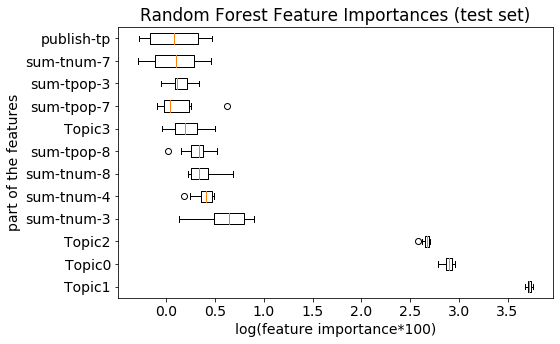

In [287]:
f_names = list(dfn.columns)[:-1]
f_names[0] = "Topic3"
f_names = ['Topic0', 'Topic1', 'Topic2']+f_names
sorted_indcs = np.argsort(np.mean(f_imps,axis=0))[::-1]
f_imp_df = pd.DataFrame(np.log(np.array(f_imps).T[sorted_indcs]*100), index = np.array(f_names)[sorted_indcs])
f_imp_df = f_imp_df.iloc[:12,:]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.boxplot(f_imp_df,labels = f_imp_df.index,vert=False)
#plt.axvline(test_score,label='test score')
plt.title("Random Forest Feature Importances (test set)")
plt.xlabel('log(feature importance*100)')
plt.ylabel('part of the features')
#plt.legend()
plt.tight_layout()
plt.show()

In [289]:
def ML_pipeline_kfold_rtest_gbr(X,y,random_state):
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    r2_scores = []
    f_imp = []

    # preprocessing
    mmx_ft = np.arange(3,36)
    ohe_ft = [0]
    kpt_ft = [1,2]
        
    scaler = MinMaxScaler()
    X_train_mmx = scaler.fit_transform(X_train[:,mmx_ft])
    X_t_mmx = scaler.transform(X_test[:,mmx_ft])
        
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    X_train_ohe = ohe.fit_transform(X_train[:,ohe_ft])
    X_t_ohe = ohe.transform(X_test[:,ohe_ft])

    X_train = np.concatenate((X_train_mmx, X_train_ohe, X_train[:,kpt_ft]),axis=1)
    X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
                     
    for rstt in np.arange(35,35*6,35):
        reg = GradientBoostingRegressor(max_depth = 6, n_estimators = 100, min_samples_split = 0.1, random_state = rstt)
        reg.fit(X_train,y_train)
        test_scores.append(mean_squared_error(y_test,reg.predict(X_t)))
        r2_scores.append(r2_score(y_test,reg.predict(X_t)))
        f_imp.append(reg.feature_importances_)
   
    return np.array(test_scores), np.array(r2_scores),np.mean(np.array(f_imp),0)


In [291]:
test_scores = []
r2_scores = []
f_imps = []
for rs in range(1,11):
    test_score, r2_scr, f_imp = ML_pipeline_kfold_rtest_gbr(X, y ,42*rs)
    test_scores.append(test_score)
    r2_scores.append(r2_scr)
    f_imps.append(f_imp)
    print('MSE :',np.around(np.mean(test_score),2),'+/-',np.around(np.std(test_score),5), '\t R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),4))
print('MSE :',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
print('R2 :',np.around(np.mean(r2_scores),2),'+/-',np.around(np.std(r2_scores),2))

MSE : 0.34 +/- 2e-05 	 R2 : 0.48 +/- 0.0
MSE : 0.38 +/- 2e-05 	 R2 : 0.47 +/- 0.0152
MSE : 0.38 +/- 4e-05 	 R2 : 0.47 +/- 0.0124
MSE : 0.39 +/- 0.00019 	 R2 : 0.45 +/- 0.025
MSE : 0.4 +/- 0.0 	 R2 : 0.45 +/- 0.0242
MSE : 0.35 +/- 0.00011 	 R2 : 0.45 +/- 0.0226
MSE : 0.37 +/- 0.00018 	 R2 : 0.45 +/- 0.0213
MSE : 0.34 +/- 0.00011 	 R2 : 0.46 +/- 0.021
MSE : 0.34 +/- 0.0 	 R2 : 0.46 +/- 0.02
MSE : 0.34 +/- 2e-05 	 R2 : 0.46 +/- 0.0193
MSE : 0.36 +/- 0.02
R2 : 0.46 +/- 0.02


/Users/zysophia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


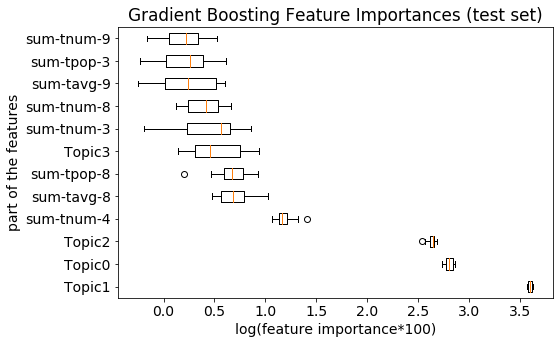

In [294]:
f_names = list(dfn.columns)[:-1]
f_names[0] = "Topic3"
f_names = ['Topic0', 'Topic1', 'Topic2']+f_names
sorted_indcs = np.argsort(np.mean(f_imps,axis=0))[::-1]
f_imp_df = pd.DataFrame(np.log(np.array(f_imps).T[sorted_indcs]*100), index = np.array(f_names)[sorted_indcs])
f_imp_df = f_imp_df.iloc[:12,:]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.boxplot(f_imp_df,labels = f_imp_df.index,vert=False)
#plt.axvline(test_score,label='test score')
plt.title("Gradient Boosting Feature Importances (test set)")
plt.xlabel('log(feature importance*100)')
plt.ylabel('part of the features')
#plt.legend()
plt.tight_layout()
plt.show()

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# preprocessing
mmx_ft = np.arange(3,36)
ohe_ft = [0]
kpt_ft = [1,2]

scaler = MinMaxScaler()
X_train_mmx = scaler.fit_transform(X_train[:,mmx_ft])
X_t_mmx = scaler.transform(X_test[:,mmx_ft])

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_train_ohe = ohe.fit_transform(X_train[:,ohe_ft])
X_t_ohe = ohe.transform(X_test[:,ohe_ft])

X_train = np.concatenate((X_train_mmx, X_train_ohe, X_train[:,kpt_ft]),axis=1)
X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
                     

grid = SVR(C = 10, gamma = 0.1)
grid.fit(X_train,y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [326]:
nr_runs = 10
scores = np.zeros([len(dfn.columns)-1,nr_runs])

test_score = grid.score(X_t,y_test)
print('test score = ',test_score)
# loop through the features
for i in range(len(dfn.columns)-1):
    print('shuffling '+str(dfn.columns[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[:,i] = np.random.permutation(X_test[:,i])
        X_t_mmx = scaler.transform(X_test_shuffled[:,mmx_ft])
        X_t_ohe = ohe.transform(X_test_shuffled[:,ohe_ft])
        X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
        acc_scores.append(grid.score(X_t,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.45219192337551795
shuffling Topic
   shuffled test score: 0.398 +/- 0.015
shuffling sentimenttitle
   shuffled test score: 0.452 +/- 0.0
shuffling sentimenthead
   shuffled test score: 0.452 +/- 0.0
shuffling publish-tp
   shuffled test score: 0.264 +/- 0.022
shuffling last-popu
   shuffled test score: 0.318 +/- 0.015
shuffling sum-popu
   shuffled test score: -0.001 +/- 0.027
shuffling sum-tpop-0
   shuffled test score: 0.425 +/- 0.007
shuffling sum-tpop-1
   shuffled test score: 0.424 +/- 0.005
shuffling sum-tpop-2
   shuffled test score: 0.453 +/- 0.003
shuffling sum-tpop-3
   shuffled test score: 0.43 +/- 0.008
shuffling sum-tpop-4
   shuffled test score: 0.421 +/- 0.005
shuffling sum-tpop-5
   shuffled test score: 0.417 +/- 0.007
shuffling sum-tpop-6
   shuffled test score: 0.44 +/- 0.012
shuffling sum-tpop-7
   shuffled test score: 0.419 +/- 0.006
shuffling sum-tpop-8
   shuffled test score: 0.459 +/- 0.003
shuffling sum-tpop-9
   shuffled test score: 0.445 +/- 0.

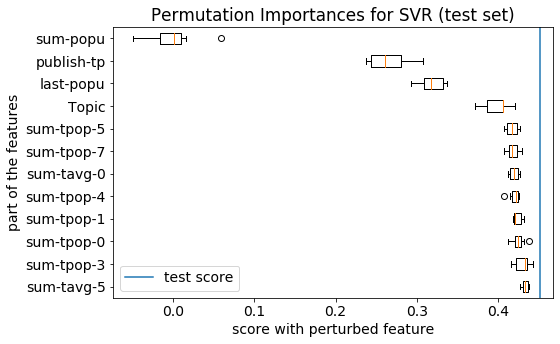

In [327]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.boxplot(scores[sorted_indcs].T[:,-12:],labels=dfn.columns[:-1][sorted_indcs][-12:],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances for SVR (test set)")
plt.xlabel('score with perturbed feature')
plt.ylabel('part of the features')
plt.legend()
plt.tight_layout()
plt.show()

In [322]:
grid = GradientBoostingRegressor(max_depth = 6, n_estimators = 100, min_samples_split = 0.1, random_state = 42)
grid.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=0.1,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [323]:
nr_runs = 10
scores = np.zeros([len(dfn.columns)-1,nr_runs])

test_score = grid.score(X_t,y_test)
print('test score = ',test_score)
# loop through the features
for i in range(len(dfn.columns)-1):
    print('shuffling '+str(dfn.columns[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[:,i] = np.random.permutation(X_test[:,i])
        X_t_mmx = scaler.transform(X_test_shuffled[:,mmx_ft])
        X_t_ohe = ohe.transform(X_test_shuffled[:,ohe_ft])
        X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
        acc_scores.append(grid.score(X_t,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.4841059816668376
shuffling Topic
   shuffled test score: 0.475 +/- 0.003
shuffling sentimenttitle
   shuffled test score: 0.481 +/- 0.0
shuffling sentimenthead
   shuffled test score: 0.481 +/- 0.0
shuffling publish-tp
   shuffled test score: 0.3 +/- 0.015
shuffling last-popu
   shuffled test score: 0.222 +/- 0.023
shuffling sum-popu
   shuffled test score: 0.152 +/- 0.038
shuffling sum-tpop-0
   shuffled test score: 0.452 +/- 0.006
shuffling sum-tpop-1
   shuffled test score: 0.478 +/- 0.002
shuffling sum-tpop-2
   shuffled test score: 0.477 +/- 0.002
shuffling sum-tpop-3
   shuffled test score: 0.482 +/- 0.001
shuffling sum-tpop-4
   shuffled test score: 0.481 +/- 0.002
shuffling sum-tpop-5
   shuffled test score: 0.476 +/- 0.003
shuffling sum-tpop-6
   shuffled test score: 0.48 +/- 0.003
shuffling sum-tpop-7
   shuffled test score: 0.468 +/- 0.005
shuffling sum-tpop-8
   shuffled test score: 0.48 +/- 0.001
shuffling sum-tpop-9
   shuffled test score: 0.477 +/- 0.002


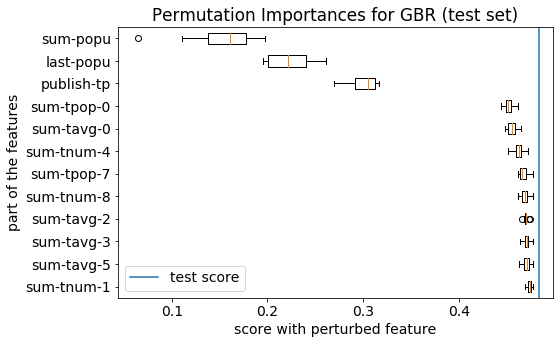

In [324]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.boxplot(scores[sorted_indcs].T[:,-12:],labels=dfn.columns[:-1][sorted_indcs][-12:],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances for GBR (test set)")
plt.xlabel('score with perturbed feature')
plt.ylabel('part of the features')
plt.legend()
plt.tight_layout()
plt.show()

In [318]:
grid = RandomForestRegressor(max_depth = 10, n_estimators = 100, min_samples_split = 0.025, random_state = 42)
grid.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=0.025,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [319]:
nr_runs = 10
scores = np.zeros([len(dfn.columns)-1,nr_runs])

test_score = grid.score(X_t,y_test)
print('test score = ',test_score)
# loop through the features
for i in range(len(dfn.columns)-1):
    print('shuffling '+str(dfn.columns[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[:,i] = np.random.permutation(X_test[:,i])
        X_t_mmx = scaler.transform(X_test_shuffled[:,mmx_ft])
        X_t_ohe = ohe.transform(X_test_shuffled[:,ohe_ft])
        X_t = np.concatenate((X_t_mmx, X_t_ohe, X_test[:,kpt_ft]),axis=1)
        acc_scores.append(grid.score(X_t,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.47384605546409764
shuffling Topic
   shuffled test score: 0.469 +/- 0.002
shuffling sentimenttitle
   shuffled test score: 0.475 +/- 0.0
shuffling sentimenthead
   shuffled test score: 0.475 +/- 0.0
shuffling publish-tp
   shuffled test score: 0.281 +/- 0.016
shuffling last-popu
   shuffled test score: 0.054 +/- 0.04
shuffling sum-popu
   shuffled test score: 0.203 +/- 0.035
shuffling sum-tpop-0
   shuffled test score: 0.471 +/- 0.002
shuffling sum-tpop-1
   shuffled test score: 0.475 +/- 0.001
shuffling sum-tpop-2
   shuffled test score: 0.475 +/- 0.001
shuffling sum-tpop-3
   shuffled test score: 0.471 +/- 0.005
shuffling sum-tpop-4
   shuffled test score: 0.473 +/- 0.001
shuffling sum-tpop-5
   shuffled test score: 0.475 +/- 0.001
shuffling sum-tpop-6
   shuffled test score: 0.474 +/- 0.0
shuffling sum-tpop-7
   shuffled test score: 0.474 +/- 0.001
shuffling sum-tpop-8
   shuffled test score: 0.476 +/- 0.0
shuffling sum-tpop-9
   shuffled test score: 0.473 +/- 0.002


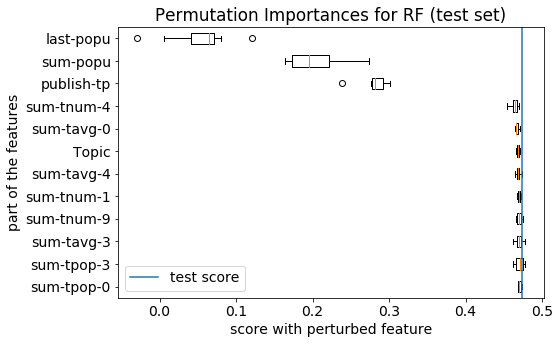

In [321]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.boxplot(scores[sorted_indcs].T[:,-12:],labels=dfn.columns[:-1][sorted_indcs][-12:],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances for RF (test set)")
plt.xlabel('score with perturbed feature')
plt.ylabel('part of the features')
plt.legend()
plt.tight_layout()
plt.show()